In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import seaborn as sns
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics

# Data Structure

## 1.1 Load data

In [3]:
path = "../input/phys591000-higgs-production"
test = pd.read_csv(path+"/High_Level_Features/Data_Project_Highlevelfeatures_Test.csv")
val = pd.read_csv(path+"/High_Level_Features/Data_Project_Highlevelfeatures_Val.csv")
train = pd.read_csv(path+"/High_Level_Features/Data_Project_Highlevelfeatures_Train.csv")
val_dict = pd.read_csv("/kaggle/input/phys591000-higgs-production/Data_Project_Val/val_dict.csv")

low_Train = pd.read_csv("/kaggle/input/phys591000-higgs-production/Data_Constituent/Data_Constituent_Train.csv")
low_Val = pd.read_csv("/kaggle/input/phys591000-higgs-production/Data_Constituent/Data_Constituent_Val.csv")
low_Test = pd.read_csv("/kaggle/input/phys591000-higgs-production/Data_Constituent/Data_Constituent_Test.csv")


In [4]:
Total_Data_HLF = pd.concat([val,train])
Total_Data_HLF = pd.concat([test,Total_Data_HLF])
print(len(Total_Data_HLF))

from sklearn.model_selection import train_test_split
train,temp = train_test_split(Total_Data_HLF, random_state=1000, train_size=0.63)
test,val = train_test_split(temp, random_state=1000, train_size=0.5)

# #print(len(Train_Data_HLF))
# #print(len(Test_Data_HLF))

220000


## 1.2 Check shape of data

In [5]:
print("shape of test data:", test.shape)
print("shape of validation data:", val.shape)
print("shape of train data:", train.shape)

shape of test data: (40700, 17)
shape of validation data: (40700, 17)
shape of train data: (138600, 17)


## 1.3 see the feature of each table

In [6]:
train.head()

,higgs_pt,higgs_eta,higgs_m,non_higgs_leading_pt,non_higgs_leading_eta,non_higgs_leading_m,mjj,girth,CIJS,SIJS,DeltaEta,weight,isGGH,isVBF,isVH,isttH,eventindex
13725,1059.267876,0.356652,125.911904,632.724495,0.719442,101.877781,1453.961449,0.091795,0.748819,0.067473,1.757716,-0.000212,0,1,0,0,93725
10133,425.303594,0.706715,125.000171,333.675140,1.474978,104.846186,963.980036,0.259643,0.012990,0.495974,4.176346,0.541775,1,0,0,0,10133
31657,1049.980500,0.667234,144.048706,1055.356590,0.136908,239.676557,737.345242,0.190591,0.170357,0.590838,0.103373,0.000439,0,0,0,1,91657
9435,1179.065969,1.119483,133.108042,1214.206284,1.413638,99.754352,431.904425,0.032117,0.949237,0.025854,0.573758,-0.005601,1,0,0,0,99435
16070,404.027341,-1.181485,101.093913,428.561172,-0.719154,73.862253,238.207967,0.147204,0.210792,0.624083,0.239114,0.544194,1,0,0,0,16070


In [7]:
features = ["higgs_pt", "higgs_eta", "higgs_m", "non_higgs_leading_pt", "non_higgs_leading_eta", "non_higgs_leading_m", "mjj" ,"girth", "CIJS", "SIJS", "DeltaEta", "weight"]
#features = ["higgs_pt", "non_higgs_leading_pt", "non_higgs_leading_eta", "mjj"]

train_array = train[features]
train_array = np.array(train_array)

test_array = test[features]
test_array = np.array(test_array)

val_array = val[features]
val_array = np.array(val_array)

In [8]:
label = ["isGGH", "isVBF", "isVH", "isttH"]

#train["notVBF"] = train["isGGH"] + train["isttH"] + train["isVH"]
#val["notVBF"] = val["isGGH"] + val["isttH"] + val["isVH"]

#train["notGGH"] = train["isVBF"] + train["isttH"] + train["isVH"]
#val["notGGH"] = val["isVBF"] + val["isttH"] + val["isVH"]

#label = ["isVBF", "notVBF"]
#label = ["isGGH", "notGGH"]
target_train = train[label]
target_train = np.array(target_train)

target_test = test[label]
target_test = np.array(target_test)

target_val = val[label]
target_val = np.array(target_val)

In [19]:
"""
Define the Optimizer
"""
opt = keras.optimizers.Adadelta(learning_rate=0.01)


"""
Compile Model
"""

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(12,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
#model.add(Dense(4, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

"""
Print Architecture
"""
model.summary()

"""
Model Training
"""
History_jet = model.fit(train_array, target_train,
               validation_data= (val_array, target_val),
               batch_size=512,
               epochs=50,
               verbose=1
              )

"""
Save Model
"""
model.save("./model_DNN.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               3328      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


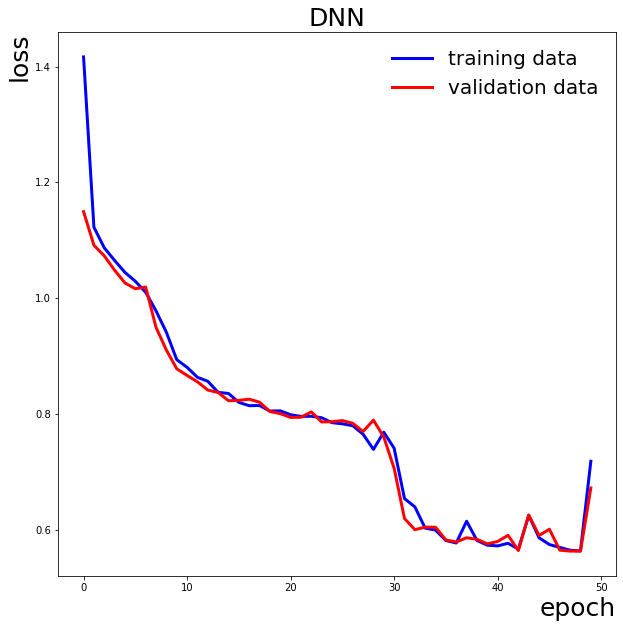

Validation accuracy is [0.6718290448188782, 0.7438329458236694]


In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Please code in this cell

print(History_jet.history.keys())


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet.history["val_loss"], label='validation data',c='red',linewidth = 3)
#plt.ylim(0,1)
plt.title("DNN", fontsize=25)
ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

scores = model.evaluate(val_array, target_val, verbose=0)
print("Validation accuracy is {}".format(scores))

In [21]:
model = load_model("./model_DNN.h5")

prediction_train = model.predict(train_array)
prediction_test = model.predict(test_array)

scores = model.evaluate(test_array, target_test, verbose=0)
print("Test accuracy is {}".format(scores))



Test accuracy is [0.6737766861915588, 0.7447911500930786]


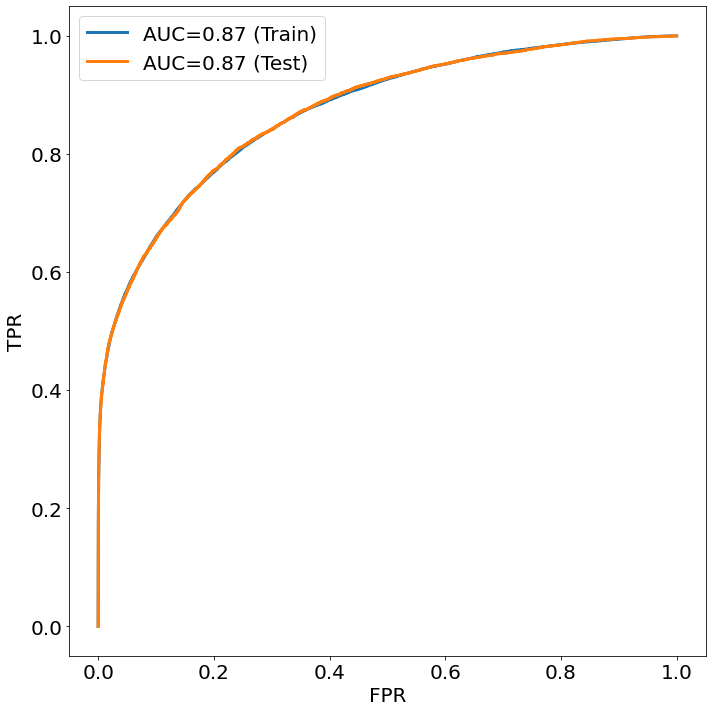

In [22]:
axis = 0
auc_train = metrics.roc_auc_score(target_train[:,axis],prediction_train[:,axis])
auc_test = metrics.roc_auc_score(target_test[:,axis],prediction_test[:,axis])

FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(target_train[:,axis],prediction_train[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(target_test[:,axis],prediction_test[:,axis])

fig, ax = plt.subplots(1,1, figsize=(10,10))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=20) 
plt.tight_layout()

plt.show()

[[0.63437562 0.07124481 0.11953295 0.17484663]
 [0.10314294 0.7766858  0.05857741 0.06159385]
 [0.12745483 0.03986646 0.68578162 0.14689709]
 [0.05704135 0.01411231 0.04697523 0.88187111]] 



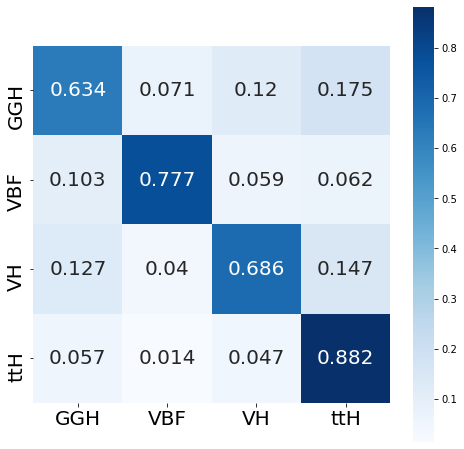

In [23]:
matrix = confusion_matrix(target_test.argmax(axis=1), prediction_test.argmax(axis=1),normalize='true')
print(matrix,'\n')

for a in range(4):
    matrix[a] = ['{:.3f}'.format(i) for i in matrix[a]] 
    
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#ax.set_title('Confusion Matrix', fontsize=30)
classes = ['GGH','VBF','VH','ttH']
sns.heatmap(matrix,cmap='Blues', square=True, annot=True, ax=ax,annot_kws={'size':20},fmt = 'n',xticklabels = classes, yticklabels = classes)
ax.tick_params(labelsize=20)

plt.show()

In [24]:
print(prediction_test)
print(target_test)

[[1.1762937e-01 3.6462772e-01 5.1562762e-01 2.1152820e-03]
 [3.3717346e-01 5.2370645e-02 4.5405889e-01 1.5639700e-01]
 [1.8373352e-01 5.0847061e-02 6.1359155e-01 1.5182780e-01]
 ...
 [2.0869961e-02 9.7622913e-01 1.9953407e-03 9.0550503e-04]
 [8.8201456e-02 3.2902922e-02 8.6449265e-01 1.4402942e-02]
 [9.4086909e-01 1.2015498e-02 2.8940814e-02 1.8174596e-02]]
[[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 ...
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]]


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#y_pred = tree_model.predict(test_array)


# confusion_matrix2 = confusion_matrix(test_array, prediction_test)
# print(target_test.shape, prediction_test.shape)
# fig, ax = plt.subplots(1, 1, figsize=(8,8))
# ax.set_title('Confusion Matrix', fontsize=30)
# classes = ['GGH','VBF','VH','ttH']
# sns.heatmap(confusion_matrix2, square=True, annot=True, ax=ax,annot_kws={'size':20},fmt = 'n',xticklabels = classes, yticklabels = classes)
# ax.tick_params(labelsize=20)

# plt.show()

In [16]:
# Total_Data_LLF = pd.concat([low_Val,low_Train])
# Total_Data_LLF = pd.concat([low_Test,Total_Data_LLF])
# print(len(Total_Data_LLF))

# from sklearn.model_selection import train_test_split
# train_L,temp_L = train_test_split(Total_Data_LLF, random_state=1000, train_size=0.62)
# test_L,val_L = train_test_split(temp_L, random_state=1000, train_size=0.5)



9261470


In [18]:
# label = ["process_ggF", "process_VBF", "process_VH", "process_ttH"]
# pd.get_dummies(train_L)
# pd.get_dummies(test_L)
# pd.get_dummies(val_L)

# target_train_L = train_L[label]
# target_train_L = np.array(target_train_L)

# target_test_L = test_L[label]
# target_test_L = np.array(target_test_L)

# target_val_L = val_L[label]
# target_val_L = np.array(target_val_L)

In [ ]:
# features_L = ["pt", "eta", "phi", "e", "rel_eta", "rel_phi"]
# #features = ["higgs_pt", "non_higgs_leading_pt", "non_higgs_leading_eta", "mjj"]

# train_array_L = train_L[features_L]
# train_array_L = np.array(train_array_L)

# test_array_L = test_L[features_L]
# test_array_L = np.array(test_array_L)

# val_array_L = val_L[features_L]
# val_array_L = np.array(val_array_L)


## Histgram for low level feature

# Discussion